In [18]:
#Importing nltk and download all packages of nltk
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [19]:
#Importing all neccessary packages
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import networkx as nx
import re
from collections import OrderedDict
from itertools import combinations
import math
from tqdm import tqdm
import unicodedata
import matplotlib.pyplot as plt

In [20]:
#Mounting the notebook with the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
#Upload a folder to you drive name as 'Author' which will have two more folders name as fake which will have data 
#Which are not written by the author and a folder named as author which will have data which is written by
#the author

#Getting the main directory from the google drive
Main_Directory = "/content/drive/MyDrive/jen/DataSet"
#Creating a dataframe having text and label
Author_Dataframe = pd.DataFrame(columns=['data','class'])
#Geting folders name in main directory which is fake and original
List_Of_Folder = os.listdir(Main_Directory)
label=0
#Loop on sub folders in main directory
for Sub_Folder in List_Of_Folder:
  #Getting the sub directory of each folder
  Sub_directory = Main_Directory + "/" + Sub_Folder
  #Gets the list of file in each subfolder
  filenames = os.listdir(Sub_directory) 
  #If folder is fake it labels it 0 and if not than label it 1
  if Sub_Folder=='fake':
    label=0
  else:
    label=1
  #Reading each file one by one in the folders of fake and original
  for eachfile in filenames:
    #Getting file directory
    finaldirectory = Sub_directory + "/" + eachfile
    #Opening each file one by one
    currentfile = open(finaldirectory, 'r')
    #Reading each file one by one
    File_content = currentfile.read()
    #Saving the file content and label define earlier in a dataframe
    temp = pd.DataFrame({"data":[File_content],"Book Name":eachfile,
                    "class":[label]})
    #Adding up dataframe to original     
    Author_Dataframe = Author_Dataframe.append(temp)

In [37]:
#Stopword_removal_and_special_tokens takes list of tokens and list of stopwords and then then check if the token is in stopword then it removes from it
#It also remove different type of characters from the list of tokens that is given as input like (- ' , . " : @ { } [ ] ? etc) 
#and it also remove the punctuation token from it after removing all these tokens it returns the remaining tokens
def Stopword_removal_and_special_tokens(Input_Tokens, stopwords):
    Clean_Input = []
    for token in Input_Tokens:
        if (token not in stopwords) and (token not in ["\n",""," ",".",",",";","&","'s", "’",":", "?", "!","(",")","”","“",\
            "'","'m","'no","*","--","...","[","]","—", "@"]):
            Clean_Input.append(token)
    return Clean_Input

#Resetting the indexes
Author_Dataframe=Author_Dataframe.reset_index(drop=True) 
#Finding stopwords using nltk
stopwords = list(set(nltk.corpus.stopwords.words("russian"))) 
#Tokenizing the each row of data frame and removing the special characters and stopwords from the tokens list
Author_Dataframe["data"] = Author_Dataframe["data"].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: Stopword_removal_and_special_tokens(x, stopwords))

#Loop to remove numbers and punctuation from data and converting it into lowercase
for i in range(len(Author_Dataframe["data"])):
    #Getting Each row from the dataframe
    Input_Tokens = Author_Dataframe["data"][i]
    #List to save clean tokens
    Clean_Tokens = []
    #Loop to check if tokens are puntuation or not and append it into clean tokens after converting it into lowercase
    for token in Input_Tokens:
        word = re.sub(r'[^\w\s]', ' ', token)
        if word != '':
            Clean_Tokens.append(word.lower())
    #Saving clean tokens in the dataframe
    Author_Dataframe["data"][i] = Clean_Tokens
    #Getting Each row from the dataframe
    Input_Tokens = Author_Dataframe["data"][i]
    #List to without numbers
    Remove_digits = []
    #Loop to check if tokens are numbers or not and append it into remove digits if its not a number
    for token in Input_Tokens:
        if token.isdigit():
            continue
        else:
            Remove_digits.append(token)
    #Saving tokens without numbers in the dataframe
    Author_Dataframe["data"][i] = Remove_digits
    #Removing white spaces tokens from list
    if(" " in Author_Dataframe["data"][i]):
        Author_Dataframe["data"][i].remove(" ")
    #Removing empty tokens from list
    if("" in Author_Dataframe["data"][i]):
        Author_Dataframe["data"][i].remove("")
print(Author_Dataframe)

                                                 data class  \
0   [без, огня, пароход, идет, час, виден, город, ...     0   
1   [будни, i, плотник, лактион, никитич, вырезыва...     0   
2   [в, родных, местах, i, ссыльный, поселенец, ен...     0   
3   [жажда, ветерок, степи, налетал, капризными, п...     0   
4   [послушайте, господин, дастих, озабоченно, ска...     0   
5   [мелеховский, двор, самом, краю, хутора, ворот...     0   
6   [лазоревая, степь, над, доном, облысевшем, сол...     1   
7   [ка, для, деда, ласковую, минуту, постреленыш,...     1   
8   [валентин, осипов, писатель, властьоткрытия, а...     1   
9   [регибы, собственно, применялось, допросах, об...     1   
10  [ком, семякине, шестовой, а, зря, посажены, не...     1   
11  [в, округ, приезжал, областной, продовольствен...     1   
12  [испытание, случай, жизни, одного, уезда, двин...     1   
13  [пастух, i, из, степи, бурой, выжженной, солнц...     1   
14  [коловерть, i, на, закате, солнца, вернулся, с...  

In [39]:
def Dumming_Variable(Document):
    return Document
print("Tf-idf Calculations")
#Tf-idf Calculation using the data features
Tfidf_Author_Vector = TfidfVectorizer(input="content", max_features=None, tokenizer=Dumming_Variable, preprocessor=Dumming_Variable)
Tfidf_Author_Vector.fit(Author_Dataframe["data"])
Author_Data_Tfidf = Tfidf_Author_Vector.transform(Author_Dataframe["data"])
#Converting Tfidf of the Author_Data into array 
Author_Data_Tfidf = Author_Data_Tfidf.toarray() 
#Getting vocabulary of the Author Data
Author_Data_Vocabulary = Tfidf_Author_Vector.get_feature_names() 
#Saving the vocabulary we just created into np array
Author_Data_Vocabulary = np.array(Author_Data_Vocabulary) 
#Creating dataframe for the Tfidf using the vocabulary
Author_Data_Tfidf = pd.DataFrame(Author_Data_Tfidf,columns=Author_Data_Vocabulary) 


#Creating word to word co-occurencces of the each words 
print("Co-Occurences Calculations")
#Getting feature name from the vocabulary
Features_Names = Author_Data_Vocabulary
#Max Window Size for the model
Window_Size=10
#Getting Word to word occurence
Word_Word_Occur  = OrderedDict((feature, 0) for feature in Features_Names)
Word_To_Word = OrderedDict( (feature,i) for i,feature in enumerate(Features_Names) )
#Getting Word to word co-occurence
Word_Word_Co_Occur = np.zeros( (len(Features_Names),len(Features_Names)) ,dtype=np.int8)
#Current window number
Windows_Number = 0; 
for i in Author_Dataframe["data"]:
    for j in range(len(i)-Window_Size):
        Windows_Number += 1
        content = set(i[j:(j+Window_Size)])
        #Calculating Co-occurences of eac words
        for token in content:
            Word_Word_Occur[token] += 1
        for First_Word,Second_Word in combinations(content,2):
            First_Word_Index = Word_To_Word[First_Word]
            Second_Word_Index = Word_To_Word[Second_Word]
            Word_Word_Co_Occur[First_Word_Index][Second_Word_Index] += 1
            Word_Word_Co_Occur[Second_Word_Index][First_Word_Index] += 1

Tf-idf Calculations


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Co-Occurences Calculations


In [7]:
print("Pointwise Mutual Information Calculations")
#Converting that word to word co-ocurrence into Pointwise mutual information
Pointwise_Mutual_Info_IJ = pd.DataFrame(Word_Word_Co_Occur, index = Features_Names,columns=Features_Names)/Windows_Number
#Converting that word to word ocurrence into Pointwise mutual information
Pointwise_Mutual_Info_I = pd.Series(Word_Word_Occur, index=Word_Word_Occur.keys())/Windows_Number
#Calculations for the Pointwise Mutual information 
for col in Pointwise_Mutual_Info_IJ.columns:
    Pointwise_Mutual_Info_IJ[col] = Pointwise_Mutual_Info_IJ[col]/Pointwise_Mutual_Info_I[col]
for row in Pointwise_Mutual_Info_IJ.index:
    Pointwise_Mutual_Info_IJ.loc[row,:] = Pointwise_Mutual_Info_IJ.loc[row,:]/Pointwise_Mutual_Info_I[row]
#Adding 1e-9(0.000000001) to the Pointwise Mutual information to the values if any value is zero
Pointwise_Mutual_Info_IJ = Pointwise_Mutual_Info_IJ + 1E-9
#Replacing NAN values in the array with 1e-9
Pointwise_Mutual_Info_IJ = Pointwise_Mutual_Info_IJ.replace(np.nan,1E-9 , regex=True)
#Replacing Negative values  with 1e-9
Pointwise_Mutual_Info_IJ[Pointwise_Mutual_Info_IJ < 0] = 1E-9 
for col in Pointwise_Mutual_Info_IJ.columns:
    Pointwise_Mutual_Info_IJ[col] = Pointwise_Mutual_Info_IJ[col].apply(lambda x: math.log(x))

Pointwise Mutual Information Calculations


In [40]:
import pickle
Pointwise_Mutual_Info_IJ=pickle.load( open( '/content/drive/MyDrive/jen/Pointwise_Mutual_Info_IJ11.P', "rb" ) )

In [7]:
#pickle.dump(  Pointwise_Mutual_Info_IJ, open( '/content/drive/MyDrive/jen/Pointwise_Mutual_Info_IJ11.P', "wb" ) )

In [41]:
#Print the tfidf
print(Author_Data_Tfidf) 

                          репрессии        10        14        18         2  \
0   0.182598  0.223211     0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.401738  0.161224     0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.171169  0.173036     0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.199222  0.083791     0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.031564  0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.797966  0.096663     0.000000  0.000000  0.000000  0.000000  0.000000   
6   0.052656  0.276140     0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.029007  0.307654     0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.770756  0.003181     0.004709  0.000000  0.000000  0.000000  0.000000   
9   0.458840  0.001986     0.000000  0.000000  0.000000  0.000000  0.000000   
10  0.323605  0.001769     0.000000  0.005238  0.005238  0.005238  0.015714   
11  0.012021  0.152992     0.000000  0.000000  0.000

In [42]:
#Printing PMI that is calculated above 
print(Pointwise_Mutual_Info_IJ)

                                     репрессии         10         14  \
            -20.723266 -20.723266     1.526545   1.526545 -20.723266   
            -20.723266 -20.723266   -20.723266 -20.723266 -20.723266   
  репрессии   1.526545 -20.723266   -20.723266 -20.723266 -20.723266   
 10           1.526545 -20.723266   -20.723266 -20.723266 -20.723266   
 14         -20.723266 -20.723266   -20.723266 -20.723266 -20.723266   
...                ...        ...          ...        ...        ...   
ячейках     -20.723266 -20.723266   -20.723266 -20.723266 -20.723266   
ячейки        0.607401 -20.723266   -20.723266 -20.723266 -20.723266   
ячменной    -20.723266 -20.723266   -20.723266 -20.723266 -20.723266   
ячмень      -20.723266 -20.723266   -20.723266 -20.723266 -20.723266   
ящика       -20.723266 -20.723266   -20.723266 -20.723266 -20.723266   

                    18          2        2 1         21         22  ...  \
            -20.723266   0.938759 -20.723266   1.631906   1.

In [43]:
#Building the graph using nx python library
print("Building Graph where Number of document is",len(Author_Data_Tfidf.index),"and word nodes are",len(Author_Data_Vocabulary))
Model_Graph = nx.Graph()
#First all we add document nodes to the graph we created
print("Adding document nodes to the graph")
Model_Graph.add_nodes_from(Author_Data_Tfidf.index) 
#Now we add word nodes to the graph
print("Adding word nodes to the graph")
Model_Graph.add_nodes_from(Author_Data_Vocabulary) 

#Nodes are adding into the graph now we have to created edges
#First create document word edges for the graph
print("Creating document word edges")
Doc_Word = [(doc,w,{"weight":Author_Data_Tfidf.loc[doc,w]}) for doc in tqdm(Author_Data_Tfidf.index, total=len(Author_Data_Tfidf.index)) for w in Author_Data_Tfidf.columns]
#Now create word-word edges in the graph
print("Creating word-word edges")

#Now construct the list having tuple which save the two words 
#And thier weight on each index wieght here is the PMI value calculated earlier
#Construct a list of word-word edges having a certain weight which means each index of list will have two words and a weight
Word_Word = []
coloumn = list(Pointwise_Mutual_Info_IJ.columns);
coloumn = [str(word) for word in coloumn]
for First_word, Second_word in tqdm(combinations(coloumn, 2), total=int(math.factorial(len(coloumn))/(math.factorial(2)*math.factorial(len(coloumn)-2)))):
    if (Pointwise_Mutual_Info_IJ.loc[First_word,Second_word] > 0):
        Word_Word.append((First_word,Second_word,{"weight":Pointwise_Mutual_Info_IJ.loc[First_word,Second_word]}))

print("Adding document word, word word edges graph")
#Adding Edges to the graph
Model_Graph.add_edges_from(Doc_Word)
Model_Graph.add_edges_from(Word_Word)
print("Graph Is Constructed")

Building Graph where Number of document is 16 and word nodes are 32042
Adding document nodes to the graph
Adding word nodes to the graph
Creating document word edges


100%|██████████| 16/16 [00:06<00:00,  2.41it/s]


Creating word-word edges


  0%|          | 237368/388800555 [00:03<1:28:01, 73563.88it/s]


KeyboardInterrupt: ignored

In [44]:
Model_Graph = pickle.load( open( '/content/drive/MyDrive/jen/Model_Graph.P', "rb" ) )

In [14]:
#pickle.dump(  Model_Graph, open( '/content/drive/MyDrive/jen/Model_Graph.P', "wb" ) )

In [45]:
#318 number of neurons in first hidden layer of the GCN Model
Size_Of_First_Hidden_Layer = 318 
#126 number of neurons in second hidden layer of the GCN Model
Size_Of_Second_Hidden_Layer = 126 

#GCN_For_Author_Data is model that have 2 hidden layer architecture for classification of book author
#Models first hidden layer has 318 neurons and models second hidden layer consist of the 126 neurons
#This model will predict wheather the given text is original written by Author or not with we 
#consider the label 0 if its not written by Author and label 1 it's written by Author 
class GCN_For_Author_Data(nn.Module):
    #Init function initialize initial weights to the first and second hidden layer of the gcn model and sets the variables for the input layer with the biases
    #Features_Matrix are the total number of features in the data
    def __init__(self, Features_Matrix, Features_Adjancy_Matrix, bias=True): 
        #Calling the Super class of GCN model to initialize the model
        super(GCN_For_Author_Data, self).__init__()   
        #Converting the given features into a type of tensor object                                  
        self.Features_Adjancy_Matrix = torch.tensor(Features_Adjancy_Matrix, requires_grad=False).float()
        #Initializing the first layer weights with the features name
        self.input_layer_weight = nn.parameter.Parameter(torch.FloatTensor(Features_Matrix, Size_Of_First_Hidden_Layer))
        #Initializing the initial variables using the wieghts we just initialize
        input_layer_variables = 2./(self.input_layer_weight.size(1)+self.input_layer_weight.size(0))
        self.input_layer_weight.data.normal_(0,input_layer_variables)
        #Initializing the second layer weights with the hidden layers 
        self.input_second_layer_weight_ = nn.parameter.Parameter(torch.FloatTensor(Size_Of_First_Hidden_Layer, Size_Of_Second_Hidden_Layer))
        #Initializing the second layer variables using the second layer wieghts we just initialize
        input_second_layer_variables = 2./(self.input_second_layer_weight_.size(1)+self.input_second_layer_weight_.size(0))
        self.input_second_layer_weight_.data.normal_(0,input_second_layer_variables)
        #Adding the biases to the wieghts
        if bias:
            #Initialize first layer bias
            self.input_layer_bias = nn.parameter.Parameter(torch.FloatTensor(Size_Of_First_Hidden_Layer))
            self.input_layer_bias.data.normal_(0,input_layer_variables)
            #Initialize second layer bias
            self.input_second_layer_bias = nn.parameter.Parameter(torch.FloatTensor(Size_Of_Second_Hidden_Layer))
            self.input_second_layer_bias.data.normal_(0,input_second_layer_variables)
        else:
            self.register_parameter("bias", None)
        self.fc1 = nn.Linear(Size_Of_Second_Hidden_Layer,2)
        
    # Its a Feed forward GCN model and this functon shows the forward pass of the model
    def forward(self, Initial_Value): 
        Initial_Value = torch.mm(Initial_Value, self.input_layer_weight)
        if self.input_layer_bias is not None:
            Initial_Value = (Initial_Value + self.input_layer_bias)
        Initial_Value = F.relu(torch.mm(self.Features_Adjancy_Matrix, Initial_Value))
        Initial_Value = torch.mm(Initial_Value, self.input_second_layer_weight_)
        if self.input_second_layer_bias is not None:
            Initial_Value = (Initial_Value + self.input_second_layer_bias)
        Initial_Value = F.relu(torch.mm(self.Features_Adjancy_Matrix, Initial_Value))
        return self.fc1(Initial_Value)

In [46]:
#Ratio used to split training data into two equal chunks one for training purpose other for testing purpose
Ratio_To_Split_Data=0.5 

#Creating_Input_Matrix helps to create the indentity matrix which is used as a input in GCN Model
def Creating_Input_Matrix():
    #Creating adjacency matrix
    Adjacency_Matrix = nx.to_numpy_array(Model_Graph, weight="weight");
    Adjacency_Matrix = Adjacency_Matrix + np.eye(Model_Graph.number_of_nodes())
    #Creating degree matrix
    Degree = []
    for deg in Model_Graph.degree(weight=None):
        if deg != 0:
            Degree.append(deg[1]**(-0.5))
        else:
            Degree.append(0)

    Degree = np.diag(Degree)
    #Creating identity matrix which have the features
    Iden_Matrix = np.eye(Model_Graph.number_of_nodes())
    #Transformed adjacency matrix
    Transformed_Adjacency_Matrix = Degree@Adjacency_Matrix@Degree 
    #Input for GCN model
    GCN_Input = Iden_Matrix 
    #Splitting the train data
    Test_Data = []
    for dataclass in Author_Dataframe["class"].unique():
        Temporary = Author_Dataframe[Author_Dataframe["class"] == dataclass]        
        Test_Data.extend(list(np.random.choice(Temporary.index, size=round(Ratio_To_Split_Data*len(Temporary)), replace=False)))
    

    #Select only certain labelled nodes for semi-supervised GCN
    Train_Data = []
    for i in range(len(Author_Dataframe)):
        if i not in Test_Data:
            Train_Data.append(i)
    
    print("Training Indexes : ", Train_Data)
    print("Test Indexes : ", Test_Data)

    #Selecting the train data and splitting labels
    Input_Selected = GCN_Input[Train_Data]; 
    Input_Selected = torch.from_numpy(Input_Selected).float()
    Train_Labels = [i for dataclass, i in enumerate(Author_Dataframe["class"]) if dataclass in Train_Data]
    #Selecting the test data and and splitting labels
    Test_Data_Selected = GCN_Input[Test_Data]; 
    Test_Data_Selected = torch.from_numpy(Test_Data_Selected).float()
    Test_Labels = [i for dataclass, i in enumerate(Author_Dataframe["class"]) if dataclass not in Train_Data]
    GCN_Input = torch.from_numpy(GCN_Input).float()
    return GCN_Input, Iden_Matrix, Transformed_Adjacency_Matrix, Train_Data, Train_Labels, Test_Labels, Test_Data
    

#Get Accuracy takes original label and predicted labels and find the accuracy and return it
def GetAccuracy(Predictied, Original):
    _, labels = Predictied.max(1); 
    labels = labels.numpy()
    labels = list(labels)
    sumlabel = 0
    for i in range(len(labels)):
      if(labels[i]==Original[i]):
        sumlabel+=1
    return sumlabel/len(labels)

In [47]:
#Number of classes in the Author author prediction dataset
Classes=2 
#Total Number of epochs we used for the GCN Model to train
Epochs_To_Train_Model=100 
#We add 0.15 as the learning rate of model 
Learning_Rate=0.015 
#Model ID
Model_ID=0 

#Fiding model input and splitting data into test and train
GCN_Input, Iden_Matrix, Transformed_Adjacency_Matrix, Train_Data, Train_Labels, Test_Labels, Test_Data = Creating_Input_Matrix()
#Creating the gcn model using input
Model_Network = GCN_For_Author_Data(Iden_Matrix.shape[1], Transformed_Adjacency_Matrix)
#Loss Function 
Model_Network_Criterion = nn.CrossEntropyLoss() 
#Optimizer 
Model_Network_Optimizer = optim.Adam(Model_Network.parameters(), lr=Learning_Rate)
#Scheduler
Model_Network_Scheduler = optim.lr_scheduler.MultiStepLR(Model_Network_Optimizer, milestones=[1000,2000,3000,4000,5000,6000], gamma=0.77)    
# Training the model
Model_Network.train() 
#Save accuracy for training set after each epochs
Training_Accuracy = []
#Save accuracy for test set after each epochs
Test_Accuracy = []
#Save loss for training set after each epochs
Losses_Per_Epoch = []
Predict_Output = []
#Loop runs for the number epochs define 
for epoch in range(0, Epochs_To_Train_Model):
    Model_Network_Optimizer.zero_grad()
    #Predicting the output using the model on train data
    Predicted_Output = Model_Network(GCN_Input)
    #Finding the loss on train data
    Network_Loss = Model_Network_Criterion(Predicted_Output[Train_Data], torch.tensor(Train_Labels).long())
    #Append loss into lsit  
    Losses_Per_Epoch.append(Network_Loss.item())
    Network_Loss.backward()
    Model_Network_Optimizer.step()
    Model_Network.eval()
    with torch.no_grad():
        #Predicting Test Labels
        Predicted_Labels = Model_Network(GCN_Input)
        #Calculating train accuracy
        Training_acc = GetAccuracy(Predicted_Output[Train_Data], Train_Labels); 
        #Calculating test accuracy
        Test_acc = GetAccuracy(Predicted_Labels[Test_Data], Test_Labels)
    #Appending training accuracy to the list   
    Training_Accuracy.append((epoch, Training_acc)); 
    #Appending test accuracy to the list
    Test_Accuracy.append((epoch, Test_acc))   
    #Printing accuracy for train and test and class prediction
    print("[Epoch %d ]: Evaluation accuracy of trained nodes: %.3f" % (epoch+1, Training_acc*100))
    print("[Epoch %d ]: Evaluation accuracy of test nodes: %.3f" % (epoch+1, Test_acc*100))
    print("[Epoch",epoch+1,"]: Predicted Labels of trained nodes: ",Predicted_Output[Train_Data].max(1)[1])
    print("[Epoch",epoch+1,"]: Predicted Labels of test nodes: ",Predicted_Labels[Test_Data].max(1)[1])
    Predict_Output = Predicted_Labels[Test_Data].max(1)[1]
    print()
    #Trainig again model to give more accurracy
    Model_Network.train()
    Model_Network_Scheduler.step()


    


Training Indexes :  [0, 2, 4, 6, 7, 8, 9, 11]
Test Indexes :  [3, 5, 1, 10, 15, 14, 13, 12]
[Epoch 1 ]: Evaluation accuracy of trained nodes: 37.500
[Epoch 1 ]: Evaluation accuracy of test nodes: 62.500
[Epoch 1 ]: Predicted Labels of trained nodes:  tensor([0, 0, 0, 0, 0, 0, 0, 0])
[Epoch 1 ]: Predicted Labels of test nodes:  tensor([1, 1, 1, 1, 1, 1, 1, 1])

[Epoch 2 ]: Evaluation accuracy of trained nodes: 62.500
[Epoch 2 ]: Evaluation accuracy of test nodes: 62.500
[Epoch 2 ]: Predicted Labels of trained nodes:  tensor([1, 1, 1, 1, 1, 1, 1, 1])
[Epoch 2 ]: Predicted Labels of test nodes:  tensor([1, 1, 1, 1, 1, 1, 1, 1])

[Epoch 3 ]: Evaluation accuracy of trained nodes: 62.500
[Epoch 3 ]: Evaluation accuracy of test nodes: 62.500
[Epoch 3 ]: Predicted Labels of trained nodes:  tensor([1, 1, 1, 1, 1, 1, 1, 1])
[Epoch 3 ]: Predicted Labels of test nodes:  tensor([1, 1, 1, 1, 1, 1, 1, 1])

[Epoch 4 ]: Evaluation accuracy of trained nodes: 62.500
[Epoch 4 ]: Evaluation accuracy of tes

In [48]:
Books=[]
Test_Outputs=Author_Dataframe.iloc[Test_Data]
for i in Predict_Output:
  if(int(i)==0):
    Books.append("Fake")
  else:
    Books.append("Original")
Test_Outputs["Predicted_As"]=Books
print(Test_Outputs[["Book Name","Predicted_As"]])

                  Book Name Predicted_As
3                    f4.txt         Fake
5   quiet flows the don.txt         Fake
1                    f2.txt         Fake
10                   o5.txt         Fake
15                  o13.txt     Original
14                  o12.txt     Original
13                   o8.txt     Original
12                   o7.txt     Original


<ipython-input-48-ee589f4f2043>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test_Outputs["Predicted_As"]=Books


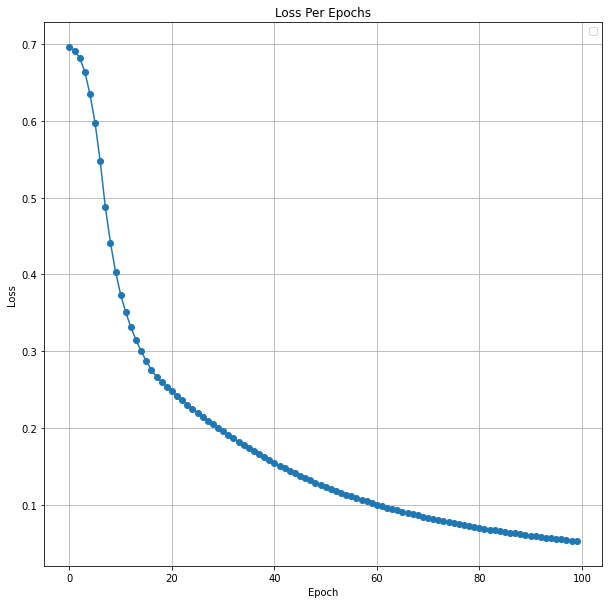

In [49]:
Training_Accuracy = np.array(Training_Accuracy); 
Test_Accuracy = np.array(Test_Accuracy)
  #Ploting Loss per epochs
plt.figure(figsize=(10, 10))
plt.plot([i for i in range(len(Losses_Per_Epoch))], Losses_Per_Epoch, marker='o',)
plt.title('Loss Per Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


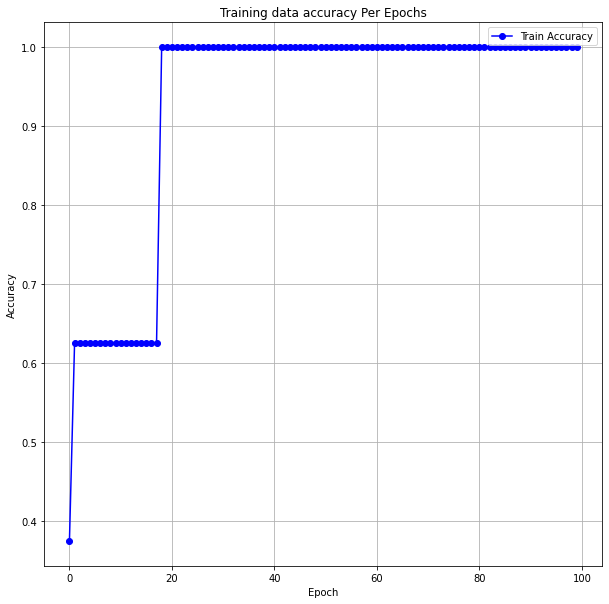

In [50]:
#Ploting Training accuracy per epochs
plt.figure(figsize=(10, 10))
plt.plot(Training_Accuracy[:,0], Training_Accuracy[:,1], color='blue', marker='o', label="Train Accuracy")
plt.title('Training data accuracy Per Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

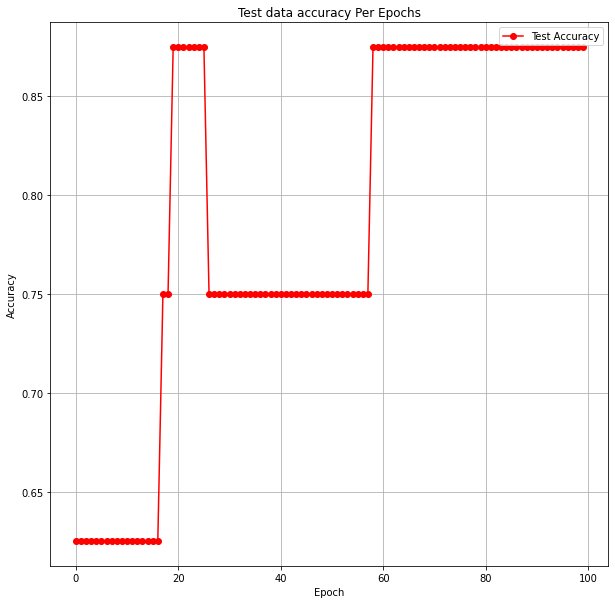

In [51]:
#Ploting Test accuracy per epochs
plt.figure(figsize=(10, 10))
plt.plot(Test_Accuracy[:,0], Test_Accuracy[:,1], color='red', marker='o',label="Test Accuracy")
plt.title('Test data accuracy Per Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()  